In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score, precision_score, recall_score
import pickle
%matplotlib inline

In [2]:
df = pd.read_csv('rb_final.csv')
df = df.drop(columns=['Unnamed: 0', '3 Cone', 'Shuttle', 'Vertical Jump', 'Position', 'PK', 'Year'])

In [3]:
df.tail()

,Round,Pick,Team,Player,Age,School,Weight,40 Time,Height (in),G,...,RecYds,RecAvg,RecTD,Plays,TotalYds,YardsPerPlay,TotalTDs,YPG,Conf,response
624,6,217,CHI,Khalil Herbert,23.0,Virginia Tech,210.0,4.46,68.0,11.0,...,179.0,17.900000,1.0,165.0,1362.0,8.254545,9.0,16.272727,ACC,3.0
625,7,233,LAR,Jake Funk,23.0,Maryland,204.0,4.49,70.0,5.0,...,68.0,6.800000,1.0,70.0,584.0,8.342857,4.0,13.600000,Big Ten,4.0
626,7,244,MIA,Gerrid Doaks,23.0,Cincinnati,NaN,NaN,NaN,30.0,...,407.0,11.305556,4.0,367.0,2119.0,5.773842,18.0,13.566667,American,NaN
627,7,256,GNB,Kylin Hill,23.0,Mississippi St.,214.0,4.51,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
628,7,257,DET,Jermar Jefferson,21.0,Oregon St.,206.0,4.57,70.0,27.0,...,299.0,6.953488,2.0,557.0,3222.0,5.784560,29.0,11.074074,Pac-12,NaN


In [4]:
df = df[(df['response'].notna()) & (df['RushYds'].notna())]
df.isna().sum()

Round            0
Pick             0
Team             0
Player           0
Age              0
School           0
Weight          17
40 Time         44
Height (in)     17
G                0
RushAtt          0
RushYds          0
RushAvg          0
RushTD           0
Rec              0
RecYds           0
RecAvg           0
RecTD            0
Plays            0
TotalYds         0
YardsPerPlay     0
TotalTDs         0
YPG              0
Conf             0
response         0
dtype: int64

In [5]:
df.shape

(263, 25)

In [6]:
# setting missing values
df = df.copy()
# df.loc[df['RushAvg'].isna(), 'RushAvg'] = 0
df.loc[df['Weight'].isna(), 'Weight'] = df['Weight'].median()
df.loc[df['40 Time'].isna(), '40 Time'] = df['40 Time'].median()
df.loc[df['Height (in)'].isna(), 'Height (in)'] = df['Height (in)'].median()

In [7]:
# removing outliers
df = df[(np.abs(stats.zscore(df['Rec'])) < 3)]
df = df[(np.abs(stats.zscore(df['RushYds'])) < 3)]
df = df[(np.abs(stats.zscore(df['RecYds'])) < 3)]
df = df[(np.abs(stats.zscore(df['RecTD'])) < 3)]
df = df[(np.abs(stats.zscore(df['TotalYds'])) < 3)]
df = df[(np.abs(stats.zscore(df['RushAtt'])) < 3)]
df = df[(np.abs(stats.zscore(df['RushTD'])) < 3)]
df.shape

(244, 25)

In [8]:
# seperating features and response and removing player name
response = df['response']
df = df.drop(columns = ['Player'])

In [9]:
# seperating data into numeric and categorical columns
df_cat = df[['Team', 'School', 'Conf']].copy()
df_num = df.drop(columns = ['Team', 'School', 'Conf']).copy()

In [10]:
# checking for high correlations with response variable
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_num.corr())

                 Round      Pick       Age    Weight   40 Time  Height (in)  \
Round         1.000000  0.980282  0.221283 -0.174165  0.279709    -0.167936   
Pick          0.980282  1.000000  0.230296 -0.171202  0.281503    -0.167248   
Age           0.221283  0.230296  1.000000 -0.014584  0.115741     0.037518   
Weight       -0.174165 -0.171202 -0.014584  1.000000  0.275338     0.643786   
40 Time       0.279709  0.281503  0.115741  0.275338  1.000000     0.055183   
Height (in)  -0.167936 -0.167248  0.037518  0.643786  0.055183     1.000000   
G            -0.062947 -0.086558 -0.118786  0.097806  0.014384    -0.089275   
RushAtt      -0.163475 -0.189556 -0.180096  0.089101  0.017655    -0.058136   
RushYds      -0.232013 -0.250286 -0.227685  0.046999 -0.054141    -0.100805   
RushAvg      -0.169959 -0.152761 -0.136822 -0.108026 -0.201670    -0.114786   
RushTD       -0.248087 -0.262755 -0.237241  0.154617 -0.017506     0.028224   
Rec          -0.064327 -0.088548 -0.149987 -0.198417

(array([ 53.,  65., 106.,  20.]),
 array([1.  , 1.75, 2.5 , 3.25, 4.  ]),
 <BarContainer object of 4 artists>)

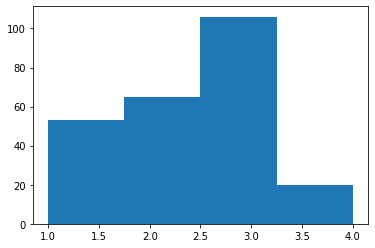

In [11]:
plt.hist(df['response'], bins=4)

In [12]:
# creating training and testing data for catboost model
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(df.drop(columns='response'), response, test_size=.2)

In [13]:
# initiating model
cat_model = CatBoostClassifier()

# using grid search to determine best parameters
grid = {'iterations': [1, 2, 3, 4, 5],
        'depth': [1, 2, 4, 6, 10],
        'learning_rate': [.3, .7, 1]}

# Pooling data before fitting
pool_train = Pool(X_train_cb, y_train_cb, cat_features=['Team', 'School', 'Conf'])

gs_result = cat_model.grid_search(grid, pool_train)

0:	learn: 1.2993101	test: 1.3230777	best: 1.3230777 (0)	total: 161ms	remaining: 0us

bestTest = 1.323077731
bestIteration = 0

0:	loss: 1.3230777	best: 1.3230777 (0)	total: 219ms	remaining: 16.2s
0:	learn: 1.2204142	test: 1.2754395	best: 1.2754395 (0)	total: 699us	remaining: 0us

bestTest = 1.275439495
bestIteration = 0

1:	loss: 1.2754395	best: 1.2754395 (1)	total: 220ms	remaining: 8.04s
0:	learn: 1.1860590	test: 1.2641400	best: 1.2641400 (0)	total: 615us	remaining: 0us

bestTest = 1.26413997
bestIteration = 0

2:	loss: 1.2641400	best: 1.2641400 (2)	total: 222ms	remaining: 5.33s
0:	learn: 1.2993101	test: 1.3230777	best: 1.3230777 (0)	total: 525us	remaining: 525us
1:	learn: 1.2315396	test: 1.2854148	best: 1.2854148 (1)	total: 1.05ms	remaining: 0us

bestTest = 1.285414774
bestIteration = 1

3:	loss: 1.2854148	best: 1.2641400 (2)	total: 224ms	remaining: 3.98s
0:	learn: 1.2204142	test: 1.2754395	best: 1.2754395 (0)	total: 678us	remaining: 678us
1:	learn: 1.1944866	test: 1.2601969	best: 1.

In [19]:
# pooling test data
pool_test = Pool(X_test_cb, y_test_cb, cat_features=['Team', 'School', 'Conf'])

# making predictions
cat_preds = cat_model.predict(pool_test)
cat_proba = cat_model.predict_proba(pool_test)

In [15]:
display(f1_score(y_test_cb, cat_preds, average='macro'))

0.398989898989899

In [16]:
# saving the initial model to a pkl file
rb_pickled_initial = pickle.dump(cat_model, open('rb_pickled_initial.pkl', 'wb'))

In [22]:
cat_proba[0][0]

0.10646422365311456

In [24]:
pd.DataFrame({
        "Chance of being a superstar": [cat_proba[0][0]],
        "Chance of being a star": [cat_proba[0][1]],
        "Chance of being a contributor": [cat_proba[0][2]],
        "Chance of being a dud": [cat_proba[0][3]]
    })

,Chance of being a superstar,Chance of being a star,Chance of being a contributor,Chance of being a dud
0,0.106464,0.355414,0.390325,0.147797
